---

# <center> **MVA RecVis 2021** <br>
# <center> **Assignment 3: Bird image classification competition**

<center> Realized By: Eya Ghamgui
<center> eya.ghamgui@telecom-paris.fr

---



## **Import Libraries**

In [ ]:
import os
import shutil
from tqdm import tqdm

import torch
torch.manual_seed(1)  
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR

import math
import numpy as np
import pandas as pd
import seaborn as sns
import PIL.Image as Image
import matplotlib.pyplot as plt
from skimage.io import imsave
from sklearn.metrics import confusion_matrix , accuracy_score , recall_score, precision_score , f1_score

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Parameters used in the notebook**

In [ ]:
path_data = '/content/drive/My Drive/A3/bird_dataset' ## To be changed to specify the folder of the data
threshold = 0.5
types = ['train' , 'val']

num_epochs = 20
batch_size = 64
image_size = 256 
num_classes = 20
features = 512
fmap_size = 8
best_loss = 100 
trigger_times = 0
patience = 5

## **Increase the Size of Validation Data** 

I used the code provided in this link: 

https://www.tutorialspoint.com/How-to-move-a-file-from-one-folder-to-another-using-Python

In [ ]:
# We have a total of 1182 images ; 100 * (200 + 103) / (1182) = 25 % ==> 
# we're going to add 10 images to each class to make the repartition 
# (25% validation and 75% training data)

n = 10 # Number of images to add
for clas in os.listdir(path_data + "/train_images"):
  
  i = 0 
  for image in os.listdir(path_data + "/train_images/"+ clas):
    if i < n : 
      pathin = path_data + "/train_images/"+clas
      pathout = path_data + "/val_images/"+clas
      shutil.move(pathin+"/"+image, pathout+"/"+image) ## Used to transfer images from folder to folder 
    i+=1

'\nn = 10 \nfor clas in os.listdir(path_data + "/train_images"):\n  i = 0 \n  for image in os.listdir(path_data + "/train_images/"+ clas):\n    if i < n : \n      pathin = path_data + "/train_images/"+clas\n      pathout = path_data + "/val_images/"+clas\n      shutil.move(pathin+"/"+image, pathout+"/"+image)\n    i+=1'

## **Crop Images**

The idea of this part is inspired from the following links: 

https://learnopencv.com/mask-r-cnn-instance-segmentation-with-pytorch/

https://github.com/antoyang/bird-classification/blob/master/Birds_Augmentation.ipynb

<bR>
In this part, I started by creating the cropped images and saving them separately. At first I worked only on the cropped data. After that I added the cropped images to the original images. Thsu, I realized that it improved the performance on the leaderboard. 

In [ ]:
def crop_image (img) :

  # I will use Mask-RCNN to crop the images 
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  model.eval()

  # Prepare the image 
  transform = transforms.Compose([transforms.ToTensor()])
  img1 = transform(img)

  # Predict the boxes 
  pred = model([img1])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]

  if pred_t != []:
    pred_t = pred_t[-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]

    # Extract bird box 
    if 'bird' in pred_class:
      p = pred_class.index('bird')
      top = math.ceil(pred_boxes[p][0][1])
      left = math.floor(pred_boxes[p][0][0])
      down = math.ceil(pred_boxes[p][1][1])
      right = math.floor(pred_boxes[p][1][0])

      # Crop the image 
      cropped_img = img.crop((left, top, right, down))
      return cropped_img

    else :
      return None 

  else: 
    return None

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


# Crop images for training and validation data 
for t in types : 
  print(t)
  if t  == 'train' : 
    name = "/train_images"
  else : 
    name = "/val_images"

  for clas in os.listdir(path_data + name):
    class_path = path_data + name + '/' + clas

    for trainim in os.listdir(class_path):
      img_path = class_path +'/'+  trainim 
      img = Image.open(img_path)
      croped = crop_image (img)
      new_path = class_path + '/' + trainim[:-4]+ 'crop.jpg'

      if croped != None :
        croped.save(new_path)
        
      else : 
        img.save(new_path)

train
val


## **Import the Data + Data Augmentation**

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.RandomAffine(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=32./255.,saturation=0.5),
    transforms.RandomRotation(20,  resample=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path_data + '/train_images',
                         transform=data_transforms),
    batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path_data + '/val_images',
                         transform=data_transforms),
    batch_size=batch_size, shuffle=False, num_workers=1)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


## **Show Some Examples**

Here we will plot a few randomly selected images from the data set.

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


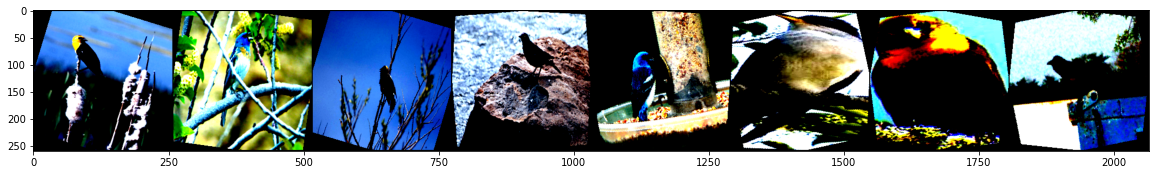

               4                7                5                3                7               18                4               16


In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(20,25))
imshow(torchvision.utils.make_grid(images[0:8]))

# print labels
print(' '.join('%16s' % int(labels[j]) for j in range(8)))

## **Pre-trained Models**

The idea of this part is inspired from the following links:

https://blog.jovian.ai/cnn-and-transfer-learning-with-pytorch-200-bird-species-image-classification-7e1f2e958a78

https://www.kaggle.com/rajeshbhat/fine-grained-image-classification-with-b-cnn-s


<br>
In this part, I will use ResNet34 as a pre-trained model. I will also add the fine-grained technique. 

### **Model 1**

In [ ]:
class Model1():
  
    def __init__(self):
        super().__init__()

        # Use a pre-trained model
        self.network = models.resnet34(pretrained=True)

        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc =nn.Sequential(
        nn.Linear(num_ftrs,64),
        nn.Tanh(),
        nn.Dropout(0.6),
        nn.Linear(64,num_classes))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

    def forward(self, x):
        return self.network(x)

### **Model 2**

In [ ]:
class Model2(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Use a pre-trained model
        self.network = models.resnet34(pretrained=True)
        layers = list(self.network.children())[:-2]
        self.features = nn.Sequential(*layers)       

        # Replace last layer
        self.fc = nn.Sequential(
        nn.Linear(features**2,64),
        nn.Tanh(),
        nn.Dropout(0.6),
        nn.Linear(64,num_classes))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.features.parameters():
            param.require_grad = False

    def unfreeze(self):
        # Unfreeze all layers
        for param in self.features.parameters():
            param.require_grad = True
        
    def forward(self, x):
        N = x.size()[0]
        x = self.features(x)
        x = x.view(N, features, fmap_size ** 2)
        x = torch.bmm(x, torch.transpose(x, 1, 2))/ (fmap_size ** 2) 
        x = x.view(N, features ** 2)
        x = torch.sqrt(x + 1e-5)
        x = F.normalize(x)
        x = self.fc(x)
        
        return x

## **Train and Validation Functions**

In [ ]:
def train(epoch, model , optimizer , log_interval):

    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(output, target)

        train_loss += loss.data.item()

        loss.backward()
        optimizer.step()

        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    return (train_loss /len(train_loader.dataset), 100. * correct / len(train_loader.dataset))

In [ ]:
def validation(model, epoch):
  
    model.eval()

    validation_loss = 0
    correct = 0

    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()

        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    validation_acc = 100. * correct / len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),validation_acc))
    
    return validation_loss , validation_acc

## **Training the Model and Fine-tune the Parameters**

<br>
Here the training is divided into two stages. The first corresponds to training only the added layers. In the second part, we continue training all layers and use a stopping criterion. 

In [ ]:
# Lists to store performances 
val_acc_list =[]
val_loss_list = []
train_acc_list =[]
train_loss_list = []

# Hyperparameters after parameter tuning
hyperparam = {'lr':1e-4, 'w_decay':1e-5, 'step_size' : 20 , 'gamma' : 0.1} 

# Define the model
model = Model2() ### The best model 
use_cuda = torch.cuda.is_available()
if torch.cuda.is_available():
  model.cuda()

optimizer = optim.Adam(params=model.parameters(), lr=hyperparam['lr'], weight_decay=hyperparam['w_decay'])
scheduler = StepLR(optimizer, step_size=hyperparam['step_size'], gamma=hyperparam['gamma'])  
loss_func = nn.CrossEntropyLoss()

################################ First Part ################################

# Freeze the parameters 
model.freeze()

for epoch in range(1, num_epochs + 1):

    train_loss , train_acc = train(epoch, model , optimizer, 1)
    val_loss , val_acc = validation(model, epoch)
    
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    scheduler.step()

################################ Second Part ################################

# Unfreeze the parameters 
model.unfreeze()

for epoch in range(1, num_epochs + 1):

    train_loss , train_acc = train(epoch, model, optimizer, 1)
    val_loss , val_acc = validation(model, epoch)
    
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    scheduler.step()
    
    # Early stopping
    if val_loss > best_loss:

      trigger_times += 1
      print('trigger times:', trigger_times)

      if trigger_times >= patience:
        print('Early stopping!\nStart to test process.')
        break

    else:
      print('trigger times: 0')
      trigger_times = 0
    
    best_loss = val_loss

# Save the model 
model_file = '/content/drive/My Drive/A3/model/' + '/model_' + str(epoch) + '.pth'
torch.save(model.state_dict(), model_file)
print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Train Epoch: 1 [0/1764 (0%)]	Loss: 2.998385
Train Epoch: 1 [64/1764 (4%)]	Loss: 3.003741
Train Epoch: 1 [128/1764 (7%)]	Loss: 2.996345
Train Epoch: 1 [192/1764 (11%)]	Loss: 3.001686
Train Epoch: 1 [256/1764 (14%)]	Loss: 3.011253
Train Epoch: 1 [320/1764 (18%)]	Loss: 2.992549
Train Epoch: 1 [384/1764 (21%)]	Loss: 2.991193
Train Epoch: 1 [448/1764 (25%)]	Loss: 2.970022
Train Epoch: 1 [512/1764 (29%)]	Loss: 2.985457
Train Epoch: 1 [576/1764 (32%)]	Loss: 2.955922
Train Epoch: 1 [640/1764 (36%)]	Loss: 2.982296
Train Epoch: 1 [704/1764 (39%)]	Loss: 2.951606
Train Epoch: 1 [768/1764 (43%)]	Loss: 2.949131
Train Epoch: 1 [832/1764 (46%)]	Loss: 2.930405
Train Epoch: 1 [896/1764 (50%)]	Loss: 2.934218
Train Epoch: 1 [960/1764 (54%)]	Loss: 2.920282
Train Epoch: 1 [1024/1764 (57%)]	Loss: 2.899075
Train Epoch: 1 [1088/1764 (61%)]	Loss: 2.882110
Train Epoch: 1 [1152/1764 (64%)]	Loss: 2.874451
Train Epoch: 1 [1216/1764 (68%)]	Loss: 2.866981
Train Epoch: 1 [1280/1764 (71%)]	Loss: 2.846310
Train Epoch: 1

## **Visualizing the Performance**

### **Accuracy and loss curves** 

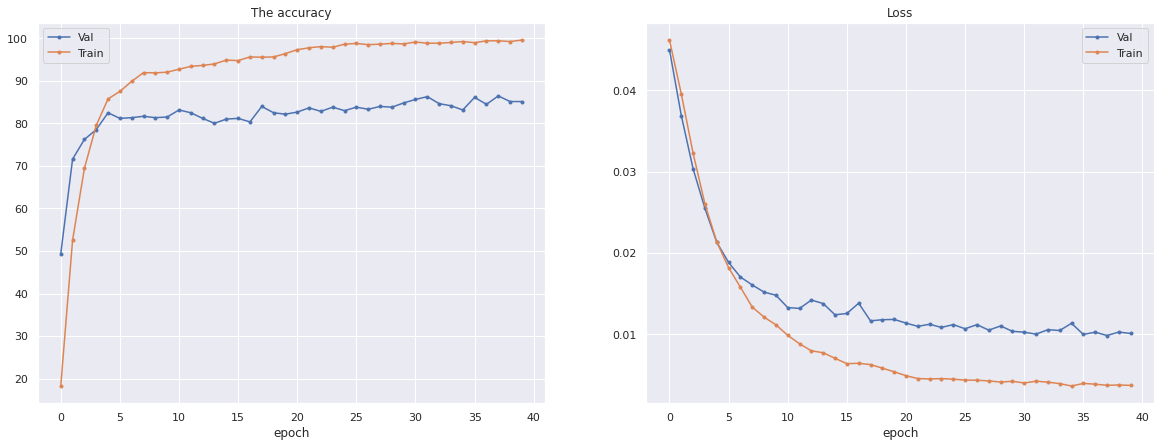

In [ ]:
sns.set()

f, ax = plt.subplots(1, 2 ,figsize=(20,7))
ax[0].plot(range(len(val_acc_list)) , val_acc_list , label= 'Val',marker='.')
ax[0].plot(range(len(train_acc_list)) , train_acc_list , label='Train',marker='.')
ax[0].set_title('The accuracy')
ax[0].legend()
ax[0].set_xlabel('epoch')

ax[1].plot(range(len(val_loss_list)) , val_loss_list , label= 'Val',marker='.')
ax[1].plot(range(len(train_loss_list)) , train_loss_list , label='Train',marker='.')
ax[1].legend()
ax[1].set_title('Loss')
ax[1].set_xlabel('epoch')

plt.show()

**Comment:** 

The algorithm is performaning very well. However, we can see an over-fitting. I think this is related to the small size of the data set. 

### **Confusion matrix for validation data**

100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


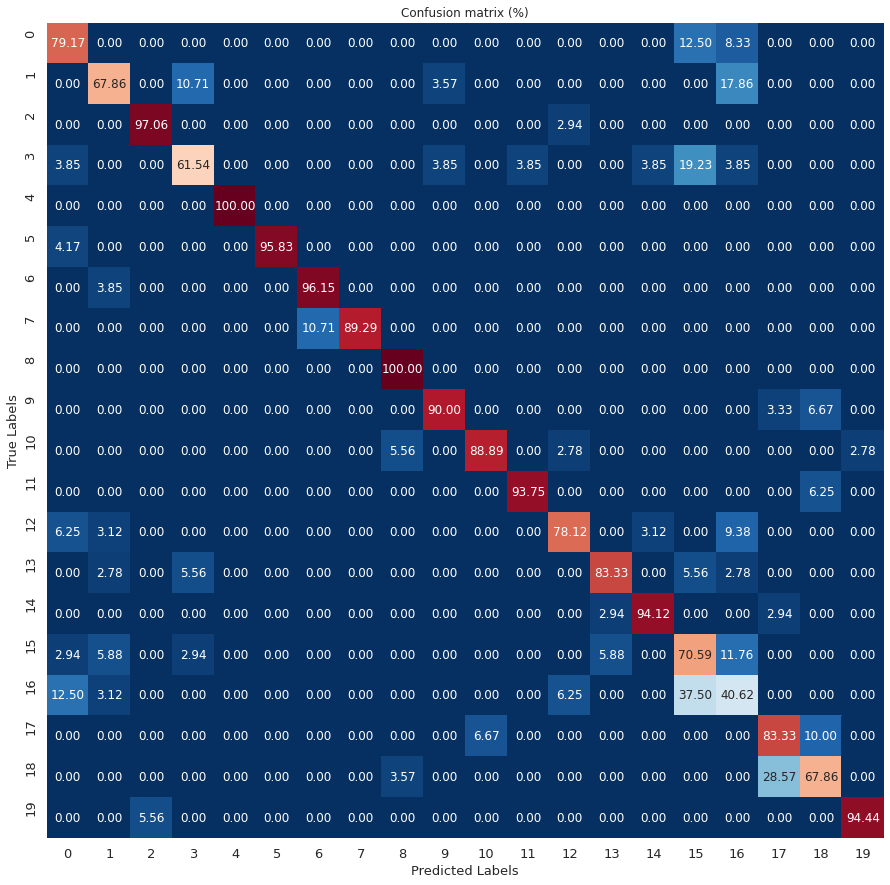

In [ ]:
def display_ConfMat_AccPerClass(y_true,y_preds):
    
    plt.figure(figsize=(15,15))
    conf_mat=confusion_matrix(y_true.numpy(), y_preds.numpy(), normalize='true')
    sns.heatmap(conf_mat * 100 , annot=True, fmt='0.2f',cmap='RdBu_r', cbar=False);
    plt.xlabel('Predicted Labels', fontsize=13);
    plt.ylabel('True Labels', fontsize=13);
    plt.xticks(ticksx,labels, fontsize=13);
    plt.yticks(ticksy,labels, fontsize=13);
    plt.title('Confusion matrix (%)')

    plt.show()

def get_predictions(data_loader):

    y_preds=torch.zeros(0,dtype=torch.long, device='cpu')
    y_true=torch.zeros(0,dtype=torch.long, device='cpu')
    
    with torch.no_grad():
        for x,y in tqdm(data_loader):
            if use_cuda:
                x,y = x.cuda(), y.cuda()
            z = model(x)
            _,pred = torch.max(z,1)

            # Append batch prediction results
            y_preds=torch.cat([y_preds,pred.view(-1).cpu()])
            y_true=torch.cat([y_true,y.view(-1).cpu()])
            
    return y_true, y_preds

# Predictions 
y_true_train, y_preds_train = get_predictions(train_loader)
y_true_valid, y_preds_valid = get_predictions(val_loader)

# Confusion matrix
labels=range(num_classes)
ticksx=np.arange(num_classes)+0.5
ticksy=np.arange(num_classes)+0.25
display_ConfMat_AccPerClass(y_true_valid, y_preds_valid)

### **Metrics**

In [ ]:
results = pd.DataFrame(index=np.arange(2), columns=['Set','F1 Score', 'Precision', 'Recall', 'Accuracy'])
base = ['Train','Validation']
i = 0

for (true,pred) in [(y_true_train, y_preds_train), (y_true_valid, y_preds_valid)]:
    p=precision_score(true,pred,average='weighted')
    r=recall_score(true,pred,average='weighted')
    f1=f1_score(true,pred,average='weighted')
    a=accuracy_score(true,pred)
    results.iloc[i]=[base[i]]+[np.round((e *100),4)  for e in [f1,p,r,a]]
    i+=1

results.set_index(['Set'])

,F1 Score,Precision,Recall,Accuracy
Set,,,,
Train,99.7732,99.7745,99.7732,99.7732
Validation,83.7781,84.3306,83.6634,83.6634


## Create test predictions 

In [ ]:
test_dir = path_data + '/test_images/mistery_category'

test_data_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

model.eval()
output_file = open('kaggle.csv', "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:

        image = pil_loader(test_dir + '/' + f)
        cropped  = crop_image(image) 
        if cropped != None :
          image = cropped

        data = test_data_transforms(image)
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()
print('Succesfully wrote kaggle.csv you can upload this file to the kaggle competition website')

100%|██████████| 517/517 [34:33<00:00,  4.01s/it]

Succesfully wrote kaggle.csv you can upload this file to the kaggle competition website
